# ST>A | Special Topics in Astrodynamics | ae4889

In [387]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras_visualizer import visualizer
from IPython.core.display import Image, display

print(f"tensorflow version: {tf.__version__}")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.spines.top'] = plt.rcParams['axes.spines.right'] = False
np.set_printoptions(precision=4, suppress=True)

JULIAN_DAY = 86400.0
raw_data = np.loadtxt('Training_data.txt')

column_names = ['cone_angle', 'flyby_time', 'transfer_time', 'euclidean_norm']
raw_dataset = pd.DataFrame(data=raw_data, columns=column_names)

sample_size = 100000
batch_size = 1000
n_layers = 5
n_nodes = 50

print(f'sample = {sample_size}, batch = {batch_size}')

tensorflow version: 2.3.0
sample = 100000, batch = 1000


In [388]:
raw_data.shape

(336700, 4)

In [389]:
dataset = raw_dataset.copy()

### Raw Data

In [390]:
dataset

,cone_angle,flyby_time,transfer_time,euclidean_norm
0,-1.570796,2460676.3,0.000000,4.823603e+10
1,-1.570796,2460676.3,0.188541,4.823590e+10
2,-1.570796,2460676.3,0.377081,4.823568e+10
3,-1.570796,2460676.3,0.565622,4.823534e+10
4,-1.570796,2460676.3,0.754163,4.823479e+10
...,...,...,...,...
336695,1.570796,2462476.3,17.911370,1.234420e+11
336696,1.570796,2462476.3,18.099911,1.254280e+11
336697,1.570796,2462476.3,18.288452,1.277353e+11
336698,1.570796,2462476.3,18.476993,1.303542e+11


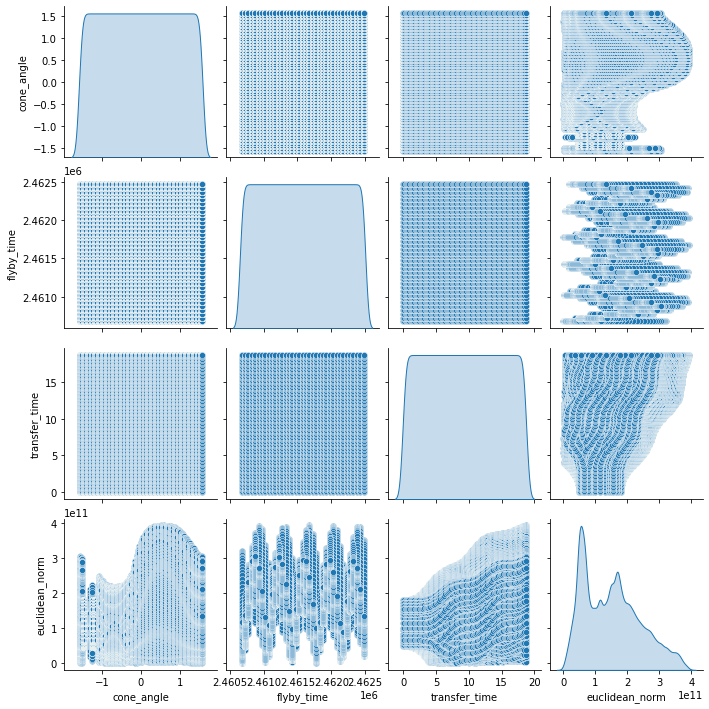

In [391]:
sns.pairplot(dataset, diag_kind="kde")

### Split Data Up

In [392]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Training Data

In [393]:
train_dataset

,cone_angle,flyby_time,transfer_time,euclidean_norm
41335,-1.186824,2460976.3,6.598926,5.563595e+10
128211,-0.383972,2461876.3,2.073948,1.200151e+11
30961,-1.291544,2461326.3,11.500985,6.814039e+10
275102,1.012291,2461326.3,0.377081,6.801200e+10
89556,-0.733038,2461026.3,10.558281,2.025413e+10
...,...,...,...,...
225690,0.523599,2462476.3,16.968667,3.116969e+11
226767,0.558505,2461176.3,12.632230,3.145044e+11
35181,-1.256637,2461576.3,15.271800,1.732841e+11
36110,-1.256637,2462076.3,1.885407,5.295581e+10


In [394]:
train_dataset.describe()

,cone_angle,flyby_time,transfer_time,euclidean_norm
count,2.693600e+05,2.693600e+05,269360.000000,2.693600e+05
mean,-4.106733e-04,2.461576e+06,9.325226,1.512494e+11
std,9.166456e-01,5.339203e+02,5.439807,8.873891e+10
min,-1.570796e+00,2.460676e+06,0.000000,4.619302e+08
25%,-8.028515e-01,2.461126e+06,4.524978,6.873824e+10
50%,2.220446e-15,2.461576e+06,9.238496,1.457827e+11
75%,8.028515e-01,2.462026e+06,13.952015,2.114252e+11
max,1.570796e+00,2.462476e+06,18.665533,3.928139e+11


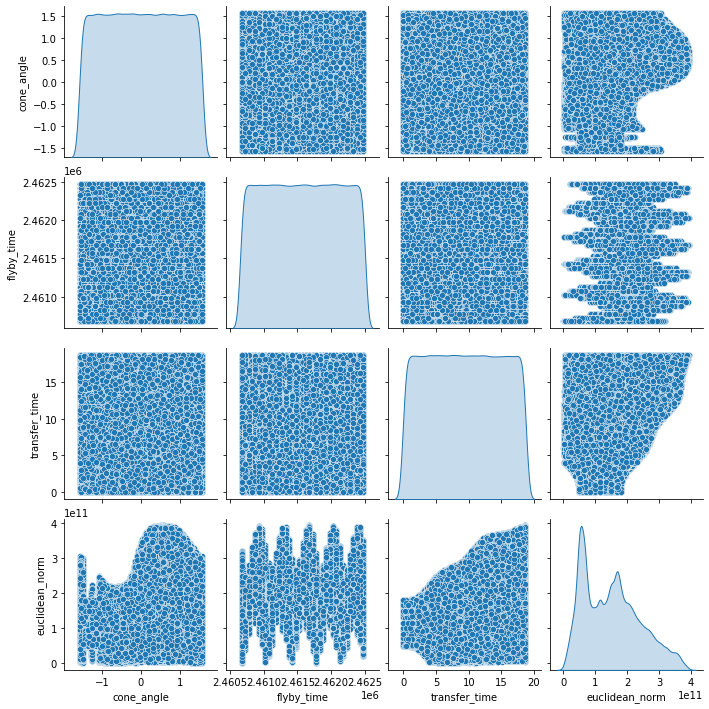

In [395]:
sns.pairplot(train_dataset, diag_kind="kde")

## Normalisation

In [396]:
def normalise_dataset(the_dataset):
    for column in column_names:
        the_dataset[column] = (the_dataset[column] - dataset[column].min()) / (dataset[column].max() - dataset[column].min())
    return the_dataset

train_data_normalised = normalise_dataset(train_dataset.copy())

In [397]:
train_data_normalised

,cone_angle,flyby_time,transfer_time,euclidean_norm
41335,0.122222,0.166667,0.353535,0.140624
128211,0.377778,0.666667,0.111111,0.304709
30961,0.088889,0.361111,0.616162,0.172494
275102,0.822222,0.361111,0.020202,0.172167
89556,0.266667,0.194444,0.565657,0.050445
...,...,...,...,...
225690,0.666667,1.000000,0.909091,0.793254
226767,0.677778,0.277778,0.676768,0.800410
35181,0.100000,0.500000,0.818182,0.440477
36110,0.100000,0.777778,0.101010,0.133793


In [398]:
train_data_normalised.describe()

,cone_angle,flyby_time,transfer_time,euclidean_norm
count,269360.000000,269360.000000,269360.000000,269360.000000
mean,0.499869,0.499988,0.499596,0.384317
std,0.291777,0.296622,0.291436,0.226172
min,0.000000,0.000000,0.000000,0.000000
25%,0.244444,0.250000,0.242424,0.174018
50%,0.500000,0.500000,0.494949,0.370384
75%,0.755556,0.750000,0.747475,0.537689
max,1.000000,1.000000,1.000000,1.000000


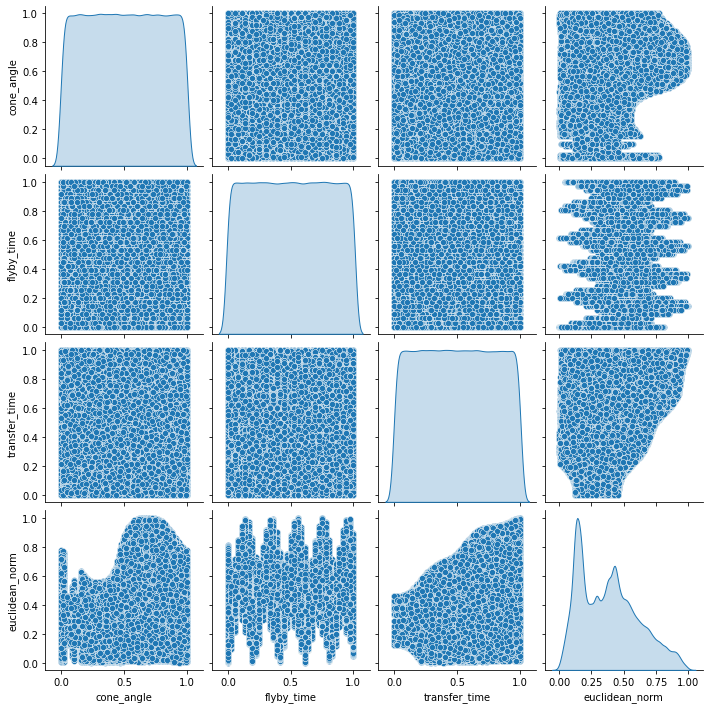

In [399]:
sns.pairplot(train_data_normalised, diag_kind="kde")

### Training data

In [400]:
train_data_normalised

,cone_angle,flyby_time,transfer_time,euclidean_norm
41335,0.122222,0.166667,0.353535,0.140624
128211,0.377778,0.666667,0.111111,0.304709
30961,0.088889,0.361111,0.616162,0.172494
275102,0.822222,0.361111,0.020202,0.172167
89556,0.266667,0.194444,0.565657,0.050445
...,...,...,...,...
225690,0.666667,1.000000,0.909091,0.793254
226767,0.677778,0.277778,0.676768,0.800410
35181,0.100000,0.500000,0.818182,0.440477
36110,0.100000,0.777778,0.101010,0.133793


In [401]:
train_data_normalised.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cone_angle,269360.0,0.499869,0.291777,0.0,0.244444,0.500000,0.755556,1.0
flyby_time,269360.0,0.499988,0.296622,0.0,0.250000,0.500000,0.750000,1.0
transfer_time,269360.0,0.499596,0.291436,0.0,0.242424,0.494949,0.747475,1.0
euclidean_norm,269360.0,0.384317,0.226172,0.0,0.174018,0.370384,0.537689,1.0


## Model


In [402]:
model = keras.Sequential([
    layers.Dense(n_nodes, activation='relu', input_shape=[3]),
    *[layers.Dense(n_nodes, activation='relu') for _ in range(n_layers - 1)],
    layers.Dense(1)
])

model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

In [403]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 50)                200       
_________________________________________________________________
dense_57 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_58 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_59 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_60 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________

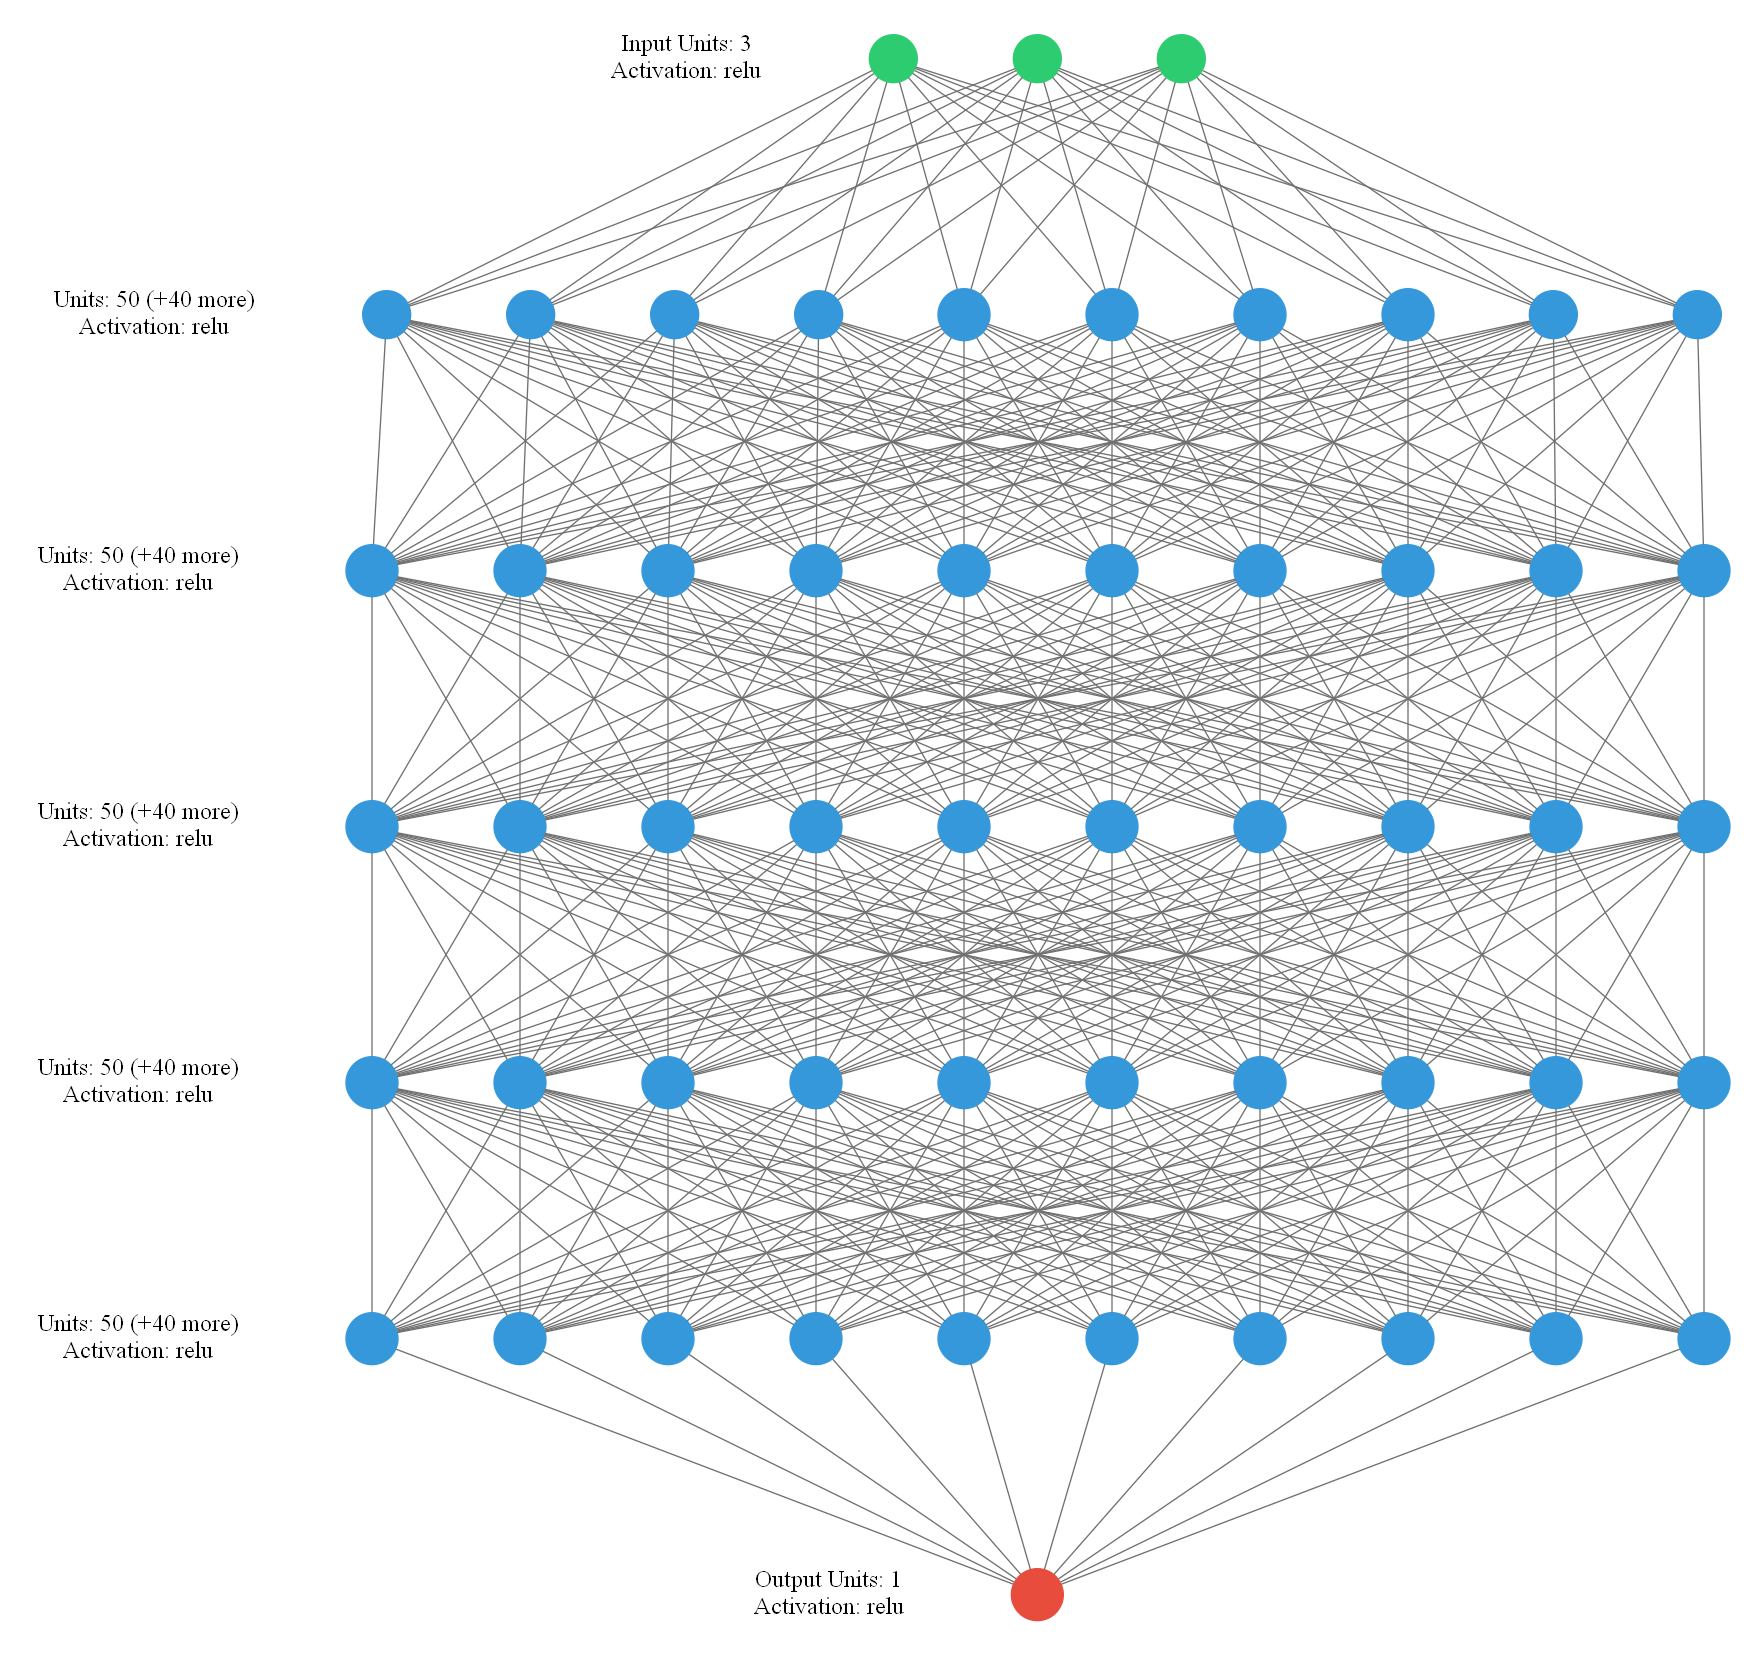

In [404]:
visualizer(model, format='png')
display((Image(filename='graph.png')))
fig.savefig('graph.png')

In [405]:
%%time
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0005,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

history = model.fit(train_data_normalised[[column_names[0], column_names[1],column_names[2]]].to_numpy(),
                    train_data_normalised[[column_names[3]]].to_numpy(),
                    validation_split=0.2,
                    epochs=1000,
                    batch_size=batch_size,
                    callbacks=[early_stop])

Epoch 1/1000
216/216 [==============================] - 1s 3ms/step - loss: 0.0376 - accuracy: 9.2813e-06 - val_loss: 0.0268 - val_accuracy: 0.0000e+00
Epoch 2/1000
216/216 [==============================] - 0s 2ms/step - loss: 0.0247 - accuracy: 9.2813e-06 - val_loss: 0.0229 - val_accuracy: 0.0000e+00
Epoch 3/1000
216/216 [==============================] - 0s 2ms/step - loss: 0.0214 - accuracy: 9.2813e-06 - val_loss: 0.0211 - val_accuracy: 0.0000e+00
Epoch 4/1000
216/216 [==============================] - 0s 2ms/step - loss: 0.0200 - accuracy: 9.2813e-06 - val_loss: 0.0194 - val_accuracy: 0.0000e+00
Epoch 5/1000
216/216 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 9.2813e-06 - val_loss: 0.0169 - val_accuracy: 0.0000e+00
Epoch 6/1000
216/216 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 9.2813e-06 - val_loss: 0.0136 - val_accuracy: 0.0000e+00
Epoch 7/1000
216/216 [==============================] - 0s 2ms/step - loss: 0.0125 - acc

In [406]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
35,0.000725,0.000009,0.000821,0.0,35
36,0.000673,0.000009,0.000674,0.0,36
37,0.000735,0.000009,0.000883,0.0,37
38,0.000718,0.000009,0.000726,0.0,38
39,0.000686,0.000009,0.000653,0.0,39


In [407]:
def plot_loss(history):
    fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True)
    fig.savefig('history.pdf')

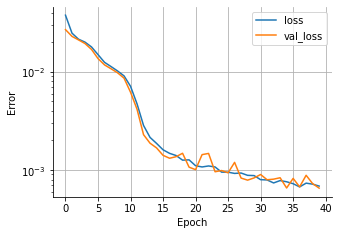

In [408]:
plot_loss(history)

In [421]:
test_dataset_raw = np.loadtxt('Asteroid2_data.txt')
column_names_test = ['cone_angle', 'flyby_time', 'transfer_time', 'euclidean_norm']
raw_test_dataset = pd.DataFrame(data=test_dataset_raw, columns=column_names_test)


test_dataset.describe()

,cone_angle,flyby_time,transfer_time,euclidean_norm
count,6.734000e+04,6.734000e+04,67340.000000,6.734000e+04
mean,1.642693e-03,2.461576e+06,9.362929,1.512969e+11
std,9.180334e-01,5.335963e+02,5.452887,8.935758e+10
min,-1.570796e+00,2.460676e+06,0.000000,4.681364e+08
25%,-8.028515e-01,2.461126e+06,4.713519,6.871833e+10
50%,2.220446e-15,2.461576e+06,9.427037,1.454929e+11
75%,8.028515e-01,2.462026e+06,14.140556,2.119415e+11
max,1.570796e+00,2.462476e+06,18.665533,3.920521e+11


In [422]:
test_data_normalised = normalise_dataset(test_dataset.copy())
test_data_input = test_data_normalised[[column_names[0], column_names[1],column_names[2]]].to_numpy()
test_data_labels = test_data_normalised[[column_names[3]]].to_numpy()

In [423]:
prediction = model.predict(test_data_input)

In [424]:
evaluation = model.evaluate(test_data_input, test_data_labels, verbose=0)

In [425]:
pd.DataFrame(data=prediction, columns=[column_names[3]])

,euclidean_norm
0,0.077439
1,0.082026
2,0.046494
3,0.045514
4,0.045546
...,...
67335,0.296239
67336,0.337849
67337,0.355384
67338,0.360163


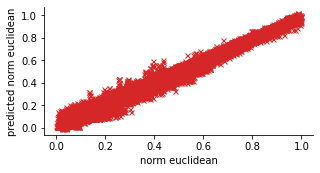

In [426]:
fig, (ax1) = plt.subplots(1, 1, figsize=(4.55, 2.5))
ax1.plot(np.linspace(0, 0.2), np.linspace(0, 0.2), '-.', c='0.5')
ax1.plot(test_data_normalised[column_names[3]], prediction[:, 0], 'x', fillstyle='none', markersize=5, c='C3', rasterized=True)
ax1.set_ylabel(fr'predicted norm euclidean')
ax1.set_xlabel(fr'norm euclidean')
fig.tight_layout()
fig.savefig('pred_vs_test.pdf', dpi=450)

In [427]:
errors = pd.DataFrame(data=(np.vstack(test_data_normalised[column_names[3]] - prediction[:, 0]).T)[0],
                      columns=["norm[euclidean norm] error"])
errors.describe()

,norm[euclidean norm] error
count,67340.000000
mean,-0.000728
std,0.025368
min,-0.199476
25%,-0.014449
50%,0.000593
75%,0.014178
max,0.165284


In [428]:
errors

,norm[euclidean norm] error
0,0.044324
1,0.039734
2,0.067676
3,0.065793
4,0.040804
...,...
67335,-0.016282
67336,-0.041804
67337,-0.056158
67338,-0.059318


In [429]:
errors.shape

(67340, 1)

In [430]:
errors_sns = errors.copy()
errors_sns.columns = ["euclidean norm"]
errors_sns = errors_sns.melt(value_name='norm[euclidean norm] error')

sample_size n_layers n_nodes batch_size
100000 5 50 1000 -0.0007283277372296323 0.02536768128486839 0.024639353547638757 6.44e-04 0.00e+00


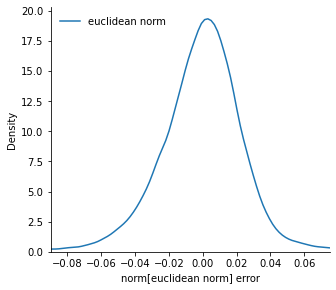

In [431]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4.5))

def plot_normal(data, **kwargs):
    mean, std = np.average(data), np.std(data)
    x = np.linspace(-0.2, 0.2, 1000)
    # ax.plot(x, norm.pdf(x, mean, std), **kwargs)
    print(mean, std, mean + std, end=' ', sep=' ')

print('sample_size', 'n_layers', 'n_nodes', 'batch_size')
print(sample_size, n_layers, n_nodes, batch_size, end=' ')
plot_normal(errors["norm[euclidean norm] error"])
print(f'{evaluation[0]:.2e} {evaluation[1]:.2e}')

g = sns.kdeplot(ax=ax, data=errors_sns, x="norm[euclidean norm] error", hue="variable")
g.set(xlim=(-0.09, 0.075))
g.get_legend().set_title(None)
g.get_legend().draw_frame(False)
fig.savefig('phase2_error_histogram.pdf')